In [4]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
import seaborn as sns

/home/hasan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def plot_heatmap(tensor,file_name):
    if tensor.dim() != 2 or tensor.shape[0] != tensor.shape[1]:
        raise ValueError("Input tensor must be of shape [n, n]")
    
    tensor = tensor.cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(tensor, cmap='viridis', cbar=True)
    plt.title("Heatmap of Tensor")
    plt.xlabel("Index")
    plt.ylabel("Index")
    # save the plot
    plt.savefig(file_name)

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def analyze_vit_and_llm_attentions(batch_id, vit_attention, llm_attention, vit_layer, vit_to_llm_mapping, raw_image):

    vit_attention = vit_attention[vit_layer]  # [batch_size, num_heads, num_context, num_context]
    llm_attention = torch.stack([i[batch_id] for i in llm_attention])  # [num_layers, num_heads, num_context, num_context]

    vit_attention = vit_attention[batch_id]  # [num_heads, num_context, num_context]
    vit_to_llm_mapping = vit_to_llm_mapping[batch_id]  # [num_tokens]

    num_tokens = vit_to_llm_mapping.shape[0]
    num_grid = int(np.ceil(np.sqrt(num_tokens)))

    vit_cls_attention = vit_attention[:, 0, -num_tokens:]  # [num_heads, num_tokens]
    vit_cls_attention = vit_cls_attention.sum(dim=0)  # [num_tokens]
    vit_cls_attention = vit_cls_attention / vit_cls_attention.sum()
    vit_cls_attention_grid = vit_cls_attention.cpu().numpy().reshape((num_grid, num_grid))

    # Plotting
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))

    # Plot the raw image
    axs[0, 0].imshow(raw_image)
    axs[0, 0].set_title('Raw Image')
    axs[0, 0].axis('off')

    # Plot the specified ViT layer attention
    cax1 = axs[0, 1].imshow(vit_cls_attention_grid, cmap='viridis', interpolation='nearest')
    axs[0, 1].set_title(f'ViT Layer {vit_layer} CLS Attention')

    # Layers to plot
    layers_to_plot = [0, 1, 2, 3] + [7,10,12,15,20,25] + [28, 29, 30, 31]

    for i, layer in enumerate(layers_to_plot):
        llm_layer_attention = llm_attention[layer]  # [num_heads, num_context, num_context]
        llm_layer_attention = llm_layer_attention.sum(dim=1)  # [num_heads, num_context]
        llm_layer_attention = llm_layer_attention.sum(dim=0)  # [num_context]
        llm_layer_attention = llm_layer_attention[vit_to_llm_mapping]  # [num_tokens]

        llm_layer_attention = llm_layer_attention / llm_layer_attention.sum()
        llm_attention_grid = llm_layer_attention.cpu().numpy().reshape((num_grid, num_grid))

        row, col = divmod(i + 2, 4)  # +2 to account for the first two plots (raw image and vit_layer attention)
        cax = axs[row, col].imshow(llm_attention_grid, cmap='viridis', interpolation='nearest')
        axs[row, col].set_title(f'LLM Layer {layer} Attention')

    plt.tight_layout()
    plt.savefig('vit_llm_attention_comparison_grids.png')
    plt.show()

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def analyze_vit_and_llm_attentions_bar_plot(batch_id, vit_attention, llm_attention, vit_layer, vit_to_llm_mapping, raw_image):
    vit_attention = vit_attention[vit_layer]  # [batch_size, num_heads, num_context, num_context]
    llm_attention = torch.stack([i[batch_id] for i in llm_attention])  # [num_layers, num_heads, num_context, num_context]

    vit_attention = vit_attention[batch_id]  # [num_heads, num_context, num_context]
    vit_to_llm_mapping = vit_to_llm_mapping[batch_id]  # [num_tokens]

    num_tokens = vit_to_llm_mapping.shape[0]
    layers_to_plot = [31]


    vit_cls_attention = vit_attention[:, 0, -num_tokens:]  # [num_heads, num_tokens]
    vit_cls_attention = vit_cls_attention.sum(dim=0)  # [num_tokens]
    vit_cls_attention = vit_cls_attention / vit_cls_attention.sum()
    vit_cls_attention = vit_cls_attention.cpu().numpy()  # [num_tokens]

    # Plotting
    fig, axs = plt.subplots(len(layers_to_plot) + 2, 1, figsize=(20, 4 * (len(layers_to_plot) + 2)))

    # Plot the raw image
    axs[0].imshow(raw_image)
    axs[0].set_title('Raw Image')
    axs[0].axis('off')

    # Plot the specified ViT layer attention as bar plot
    axs[1].bar(range(num_tokens), vit_cls_attention, color='blue')
    axs[1].set_title(f'ViT Layer {vit_layer} CLS Attention')
    axs[1].set_xlabel('Tokens')
    axs[1].set_ylabel('Attention')

    # Layers to plot

    for i, layer in enumerate(layers_to_plot):
        llm_layer_attention = llm_attention[layer]  # [num_heads, num_context, num_context]
        llm_layer_attention = llm_layer_attention.sum(dim=1)  # [num_heads, num_context]
        llm_layer_attention = llm_layer_attention.sum(dim=0)  # [num_context]
        llm_layer_attention = llm_layer_attention[vit_to_llm_mapping]  # [num_tokens]

        llm_layer_attention = llm_layer_attention / llm_layer_attention.sum()
        llm_layer_attention = llm_layer_attention.cpu().numpy()  # [num_tokens]

        axs[i + 2].bar(range(num_tokens), llm_layer_attention, color='blue')
        axs[i + 2].set_title(f'LLM Layer {layer} Attention')
        axs[i + 2].set_xlabel('Tokens')
        axs[i + 2].set_ylabel('Attention')

    plt.tight_layout()
    plt.savefig('vit_llm_attention_comparison_bars.png')
    plt.show()

# Example usage (replace with actual data)
# batch_id = 0
# vit_attention = torch.randn(24, 2, 12, 50, 50)  # example shape
# llm_attention = [torch.randn(2, 12, 50, 50) for _ in range(32)]  # example list of tensors
# vit_layer = 12
# vit_to_llm_mapping = torch.randint(0, 50, (2, 50))  # example mapping
# raw_image = np.random.rand(224, 224, 3)  # example image

# analyze_vit_and_llm_attentions(batch_id, vit_attention, llm_attention, vit_layer, vit_to_llm_mapping, raw_image)

In [8]:
model_id = "llava-hf/llava-1.5-7b-hf"

In [9]:
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    attn_implementation="eager",
).to(0)
processor = AutoProcessor.from_pretrained(model_id)

/home/hasan/my_llava_next/transformers/src/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Image successfully retrieved and saved.


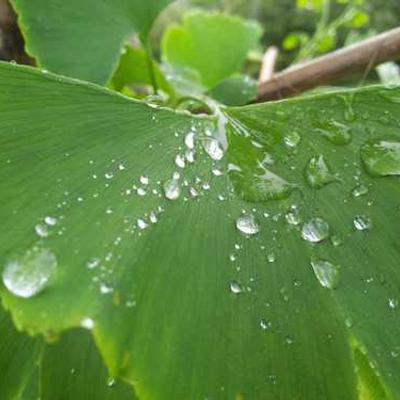

In [31]:
url = "https://picsum.photos/400"
response = requests.get(url)

if response.status_code == 200:
    with open('image.jpg', 'wb') as file:
        file.write(response.content)
    print("Image successfully retrieved and saved.")
else:
    print(f"Failed to retrieve image. HTTP Status code: {response.status_code}")
raw_image = Image.open('image.jpg')
raw_image.show()

In [32]:
prompt = "USER: <image>\nDescribe the image.\nASSISTANT:"

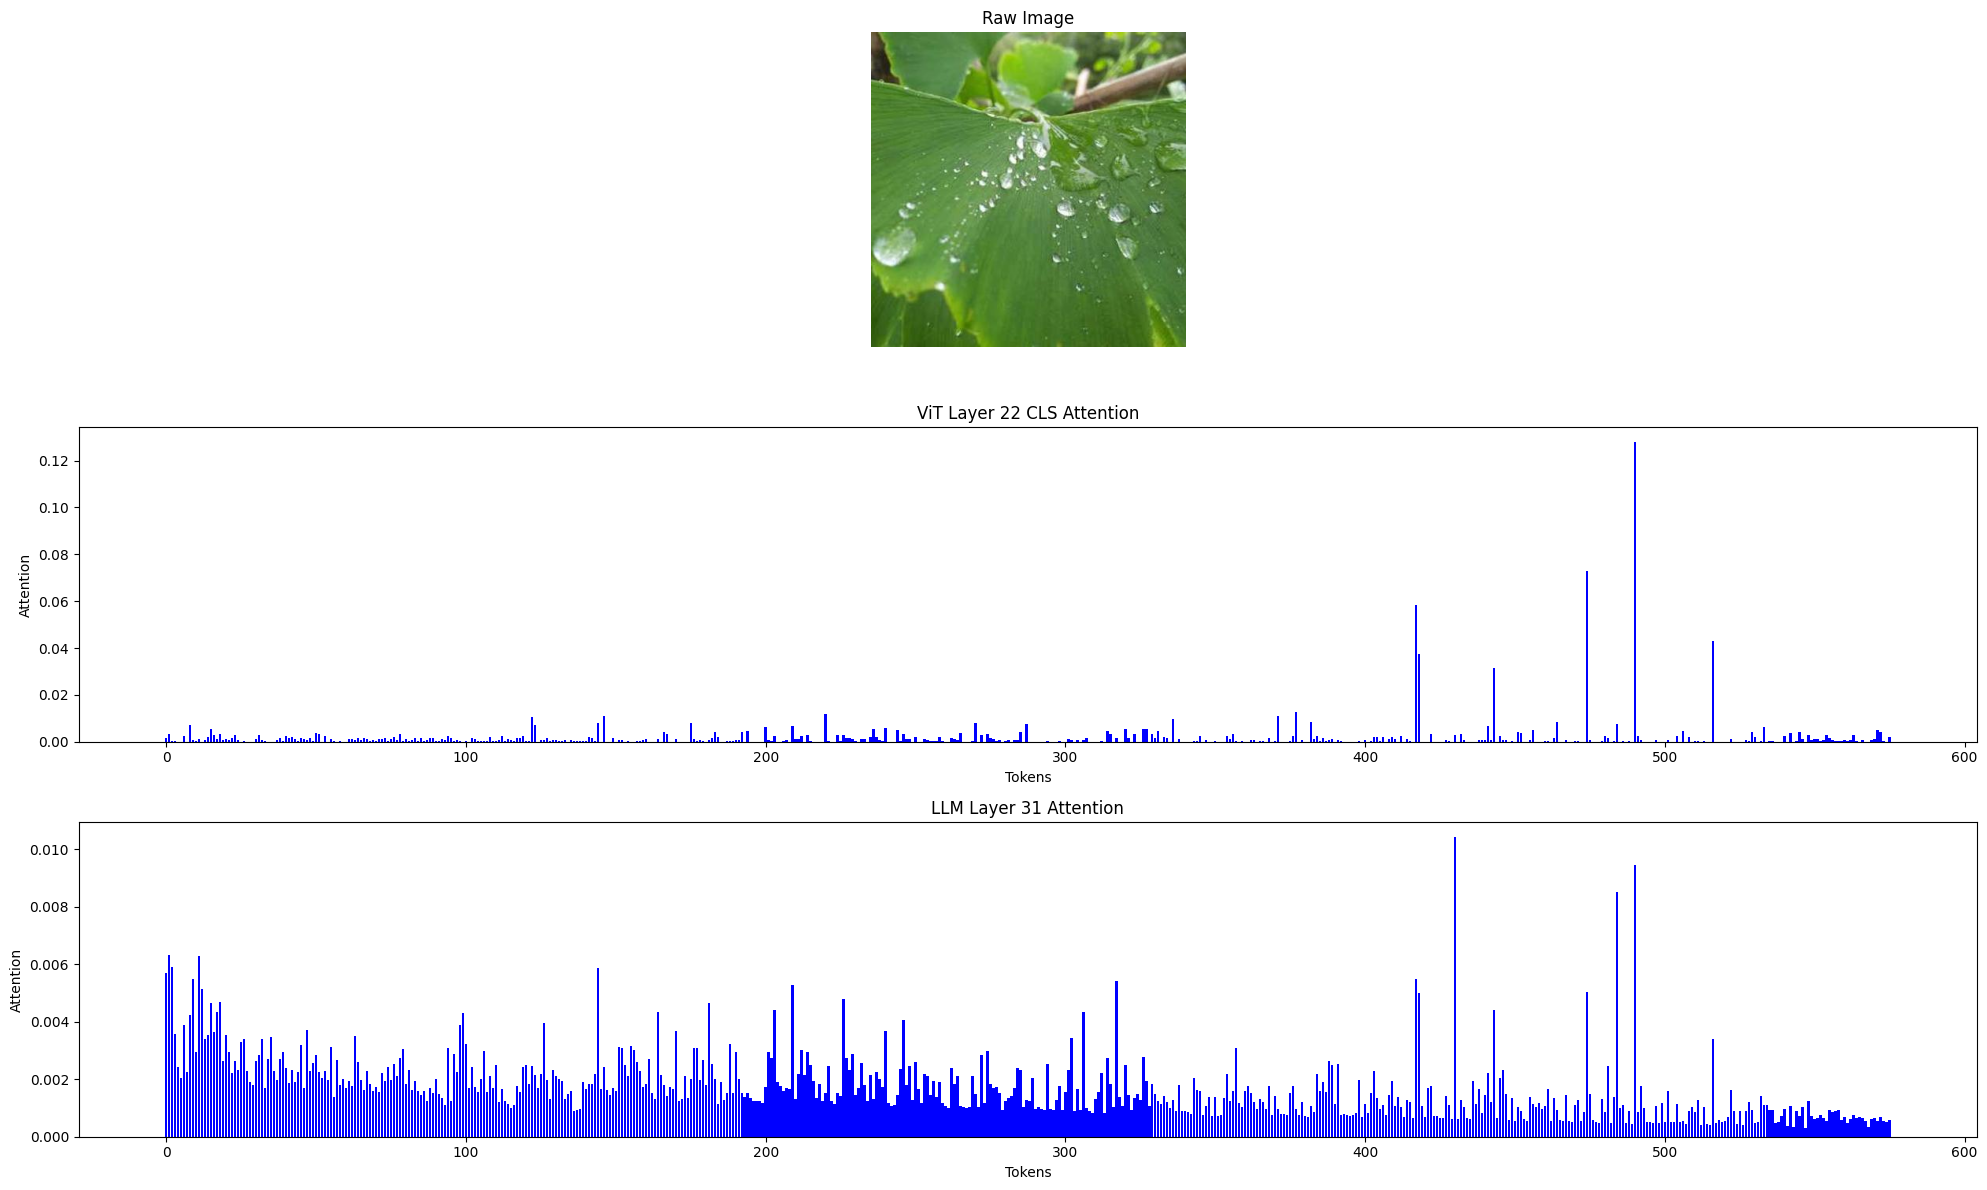

In [33]:
inputs = processor(prompt, raw_image, return_tensors='pt').to(0, torch.float16)
with torch.inference_mode():
    output = model(**inputs, output_attentions=True, return_dict = True)

analyze_vit_and_llm_attentions_bar_plot(0, output.vit_attentions, output.attentions, 22, output.vit_to_llm_mapping,raw_image)